# 项目背景

某天，业务部门拿到了一些关于客户的数据找到数据部门，苦于没有分析入手点，希望数据部门通过对这些数据的分析，给业务部门一些启示，或者提供后续分析或业务思考的建议。

基于上述场景和需求，本次分析的交付需求如下：
- 这是一次EDA任务，且业务方没有任何先验经验提供给数据部门。
- 分析结果用于业务的知识启发或后续分析的深入应用。
- 除数据统计和基本展示类的探索性分析以外的数据挖掘。

#### 数据源特征：
- USER_ID:用户ID列，整数型。该列作为用户唯一ID标志，这意味着该列不能作为聚类的特征，而只能作为用户聚类后的所属类的标记。
- AVG_ORDERS:平均用户订单数量，浮点型。
- AVG_MONEY:平均订单价值，即每单的订单价格，浮点型。
- IS_ACTIVE:是否活跃，通过其他模型得到的结果，字符串型。
- SEX:性别，以0，1，2来表示性别未知、男和女3个值。

#### 分析思路：
- 字符串型特征不能直接作训练，因为sklearn的对象一般都是数值型的向量矩阵或稀疏矩阵，而不能是原生字符串。
- SEX本质是分类型变量，不能直接参与距离计算。
- AVG_ORDERS和AVG_MONEY具有明显的量纲差异，需要作无量纲化处理。
- 分割ID列。

In [57]:
#导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score,silhouette_score

In [15]:
raw_data = pd.read_csv('cluster.txt')
#数值型特征
numeric_feature = raw_data.iloc[:,1:3]

In [18]:
#标准化
scaler = MinMaxScaler()
scaled_numeric_feature = scaler.fit_transform(numeric_feature)
print(scaled_numeric_feature[:,:2])

[[0.64200477 0.62591687]
 [0.91169451 0.80440098]
 [0.69451074 0.39608802]
 ...
 [0.3221957  0.17359413]
 [0.42004773 0.31295844]
 [0.64916468 0.40831296]]


In [25]:
#训练模型
n_cluster = 3
model_kmeans = KMeans(n_clusters = n_cluster, random_state=0)
model_kmeans.fit(scaled_numeric_feature)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [27]:
#模型效果评估
n_samples,n_features = raw_data.iloc[:,1:].shape  #总样本数，总特征数
print('sample: %d \t features: %d' % (n_samples,n_features))

sample: 1000 	 features: 4


In [31]:
#非监督式评估方法
silhouette_s = silhouette_score(scaled_numeric_feature, model_kmeans.labels_, metric='euclidean')
calinski_harabaz_s = calinski_harabaz_score(scaled_numeric_feature, model_kmeans.labels_) # Calinski和harabaz得分
unspuervised_data = {'silh':[silhouette_s], 'c&h':[calinski_harabaz_s]}
unspuervised_score = pd.DataFrame.from_dict(unspuervised_data)
print("\n",'unspuervised_score:', '\n', '-'*60)
print(unspuervised_score)


 unspuervised_score: 
 ------------------------------------------------------------
       silh          c&h
0  0.634086  2860.821834


上述结果中，显示了聚类的效果还不错。以silh为例，当其值>0.5时，说明聚类质量较优。优秀与否的基本原则是不同类别间是否具有显著的区分效应。

In [35]:
#合并数据和特征
kmeans_labels = pd.DataFrame(model_kmeans.labels_, columns = ['labels'])
#组合原始数据和标签
kmeans_data = pd.concat([raw_data, kmeans_labels], axis=1)
print(kmeans_data.head())

   USER_ID  AVG_ORDERS  AVG_MONEY IS_ACTIVE  SEX  labels
0        1        3.58      40.43        活跃    1       2
1        2        4.71      41.16       不活跃    1       2
2        3        3.80      39.49       不活跃    2       1
3        4        2.85      38.36       不活跃    1       0
4        5        3.71      38.34        活跃    1       1


In [41]:
#计算不同聚类类别的样本量和占比
label_count = kmeans_data.groupby(['labels'])['SEX'].count()
label_count_ratio = label_count / kmeans_data.shape[0]
kmeans_record_count = pd.concat([label_count,label_count_ratio], axis=1)
kmeans_record_count.columns = ['record_count', 'record_rate']
print(kmeans_record_count.head())

        record_count  record_rate
labels                           
0                332        0.332
1                337        0.337
2                331        0.331


In [44]:
#计算不同聚类类别数值型特征
kmeans_numeric_features = kmeans_data.groupby(['labels'])['AVG_ORDERS', 'AVG_MONEY'].mean()
print(kmeans_numeric_features)

        AVG_ORDERS  AVG_MONEY
labels                       
0         2.022349  38.980602
1         3.987389  39.028754
2         3.958610  40.996254


In [52]:
#计算不同聚类类别分类型特征
active_list = []
sex_gb_list = []
unique_labels = np.unique(model_kmeans.labels_)
for each_label in unique_labels:
    each_data = kmeans_data[kmeans_data['labels']==each_label]
    active_list.append(each_data.groupby(['IS_ACTIVE'])['USER_ID'].count()/each_data.shape[0])
    sex_gb_list.append(each_data.groupby(['SEX'])['USER_ID'].count()/each_data.shape[0])

kmeans_active_pd = pd.DataFrame(active_list)
kmeans_sex_gb_pd = pd.DataFrame(sex_gb_list)
kmeans_string_features = pd.concat((kmeans_active_pd,kmeans_sex_gb_pd), axis=1)
kmeans_string_features.index = unique_labels

In [53]:
#合并所有类别的分析结果

In [55]:
features_all = pd.concat((kmeans_record_count,kmeans_numeric_features,kmeans_string_features), axis=1)
print(features_all.head())

   record_count  record_rate  AVG_ORDERS  AVG_MONEY       不活跃        活跃  \
0           332        0.332    2.022349  38.980602  0.487952  0.512048   
1           337        0.337    3.987389  39.028754  0.495549  0.504451   
2           331        0.331    3.958610  40.996254  0.504532  0.495468   

          0         1         2  
0  0.003012  0.990964  0.006024  
1  0.014837  0.014837  0.970326  
2  0.984894  0.009063  0.006042  


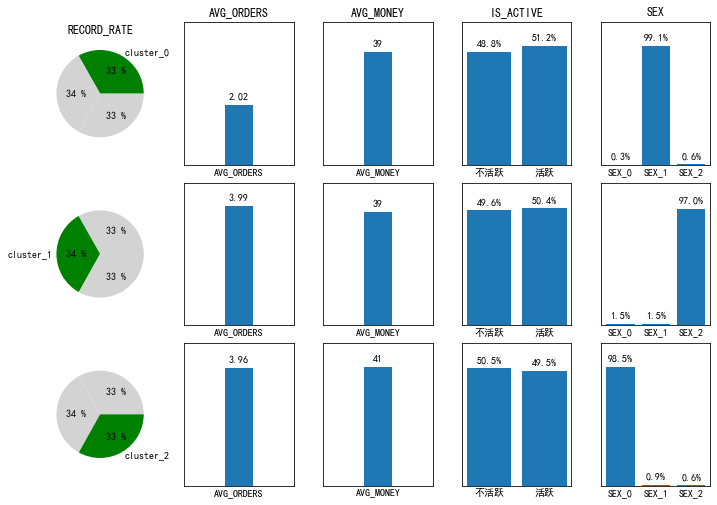

In [59]:
# 可视化图形展示
# part 1 全局配置
fig = plt.figure(figsize=(10, 7))
titles = ['RECORD_RATE','AVG_ORDERS','AVG_MONEY','IS_ACTIVE','SEX'] # 共用标题
line_index,col_index = 3,5 # 定义网格数
ax_ids = np.arange(1,16).reshape(line_index,col_index) # 生成子网格索引值
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    
# part 2 画出三个类别的占比
pie_fracs = features_all['record_rate'].tolist()
for ind in range(len(pie_fracs)):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,0][ind])
    init_labels = ['','',''] # 初始化空label标签
    init_labels[ind] = 'cluster_{0}'.format(ind) # 设置标签
    init_colors = ['lightgray', 'lightgray', 'lightgray']
    init_colors[ind] = 'g' # 设置目标面积区别颜色
    ax.pie(x=pie_fracs, autopct='%3.0f %%',labels=init_labels,colors=init_colors)
    ax.set_aspect('equal') # 设置饼图为圆形
    if ind == 0:
        ax.set_title(titles[0])
    
# part 3  画出AVG_ORDERS均值
avg_orders_label = 'AVG_ORDERS'
avg_orders_fraces = features_all[avg_orders_label]
for ind, frace in enumerate(avg_orders_fraces):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,1][ind])
    ax.bar(x=unique_labels,height=[0,avg_orders_fraces[ind],0])# 画出柱形图
    ax.set_ylim((0, max(avg_orders_fraces)*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0:# 设置总标题
        ax.set_title(titles[1])
    # 设置每个柱形图的数值标签和x轴label
    ax.text(unique_labels[1],frace+0.4,s='{:.2f}'.format(frace),ha='center',va='top')
    ax.text(unique_labels[1],-0.4,s=avg_orders_label,ha='center',va='bottom')
        
# part 4  画出AVG_MONEY均值
avg_money_label = 'AVG_MONEY'
avg_money_fraces = features_all[avg_money_label]
for ind, frace in enumerate(avg_money_fraces):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,2][ind])
    ax.bar(x=unique_labels,height=[0,avg_money_fraces[ind],0])# 画出柱形图
    ax.set_ylim((0, max(avg_money_fraces)*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0:# 设置总标题
        ax.set_title(titles[2])
    # 设置每个柱形图的数值标签和x轴label
    ax.text(unique_labels[1],frace+4,s='{:.0f}'.format(frace),ha='center',va='top')
    ax.text(unique_labels[1],-4,s=avg_money_label,ha='center',va='bottom')
        
# part 5  画出是否活跃
axtivity_labels = ['不活跃','活跃']
x_ticket = [i for i in range(len(axtivity_labels))]
activity_data = features_all[axtivity_labels]
ylim_max = np.max(np.max(activity_data))
for ind,each_data in enumerate(activity_data.values):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,3][ind])
    ax.bar(x=x_ticket,height=each_data) # 画出柱形图
    ax.set_ylim((0, ylim_max*1.2))
    ax.set_xticks([])
    ax.set_yticks([])    
    if ind == 0:# 设置总标题
        ax.set_title(titles[3])
    # 设置每个柱形图的数值标签和x轴label
    activity_values = ['{:.1%}'.format(i) for i in each_data]
    for i in range(len(x_ticket)):
        ax.text(x_ticket[i],each_data[i]+0.05,s=activity_values[i],ha='center',va='top')
        ax.text(x_ticket[i],-0.05,s=axtivity_labels[i],ha='center',va='bottom')
        
# part 6  画出性别分布
sex_data = features_all.iloc[:,-3:]
x_ticket = [i for i in range(len(sex_data))]
sex_labels = ['SEX_{}'.format(i) for i in range(3)]
ylim_max = np.max(np.max(sex_data))
for ind,each_data in enumerate(sex_data.values):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,4][ind])
    ax.bar(x=x_ticket,height=each_data) # 画柱形图
    ax.set_ylim((0, ylim_max*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0: # 设置标题
       ax.set_title(titles[4])    
    # 设置每个柱形图的数值标签和x轴label
    sex_values = ['{:.1%}'.format(i) for i in each_data]
    for i in range(len(x_ticket)):
        ax.text(x_ticket[i],each_data[i]+0.1,s=sex_values[i],ha='center',va='top')
        ax.text(x_ticket[i],-0.1,s=sex_labels[i],ha='center',va='bottom')
    
plt.tight_layout(pad=0.8) #设置默认的间距

# 结论

聚类后，群体划分为3类：
- cluster_0:显著和区分性特征是平均订单量少(仅为2.02)，男性为主的客户群体；
- cluster_1:平均订单量多(3.99)，女性为主的客户
- cluster_2:与cluster_1类似，但群体属于未知性别。

鉴于平均订单价值和活跃程度在所有类别中的分布相对意志和均匀，无法达到区分的特性，也不具有表示该群体的显著性特征。因此忽略。

最后，我们得到3类群体：**低价值的男性客户群体、高价值的女性客户群体以及高价值的未知性别客户群体。**

**衍生的分析方向**：
- 未知性别群体不应该有如此高的平均订单价值，更重要的是其样本量并不少。那么不太可能是随机发生的事件，很可能在某些方面，例如数据采集、客户体验、客户注册等方面存在某些问题，或者这类客户群体就是不愿意透露性别。可作为另一个EDA课题的开始
- 第二类高价值的女性客户群体，可做用户喜欢和特征分析，例如看一下她们都是什么事件购买、客单价平均多少、集中品类、折扣力度喜欢、来源渠道、促销方式等是否有明显的集中化倾向。